<a href="https://colab.research.google.com/github/SofiiaHeryha/Portfolio/blob/Python-projects/Sales_Owerview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Exploratory Data Analysis**

**Загальна структура датасету:**
- Кількість колонок: **18**
- Кількість унікальних сесій: **33 538**
- Період даних: **2020-11-01 – 2021-01-27**

**Типи даних:**
- Числові колонки: **5**
- Категоріальні колонки: **12**
- Datetime колонки: **1**

**Пропущені значення**

| Колонка            | Кількість пропусків | Частка пропусків (%) |
|--------------------|---------------------|----------------------|
| is_unsubscribed    | 30 757              | 91.71                |
| is_email_verified  | 30 757              | 91.71                |
| account_id         | 30 757              | 91.71                |
| browser_language   | 11 007              | 32.82                |

Більшість пропущених значень пов’язані з відсутністю авторизації користувачів
та технічними обмеженнями збору даних. Пропуски не є критичними та не впливають
на ключові бізнес-метрики.

In [ ]:
df.head()

,order_date,session_id,continent,country,device,browser,mobile_model_name,operating_system,browser_language,traffic_source_info,traffic_channel,account_id,is_email_verified,is_unsubscribed,product_category,product_name,price,short_description
0,2020-11-06,7799937037,Europe,Slovakia,mobile,Chrome,<Other>,Web,fr,referral,Paid Search,<NA>,<NA>,<NA>,Children's furniture,TROFAST,5.0,"Lid, 20x28 cm"
1,2020-11-10,4020421879,Americas,United States,desktop,Chrome,Safari,Macintosh,en,(none),Direct,653378,1,0,Children's furniture,TROFAST,5.0,"Lid, 20x28 cm"
2,2020-11-24,6717382496,Americas,United States,desktop,Chrome,Chrome,Web,en-us,referral,Social Search,<NA>,<NA>,<NA>,Children's furniture,TROFAST,5.0,"Lid, 20x28 cm"
3,2020-11-26,2093497337,Americas,United States,desktop,Chrome,Chrome,Web,en-us,(none),Direct,<NA>,<NA>,<NA>,Children's furniture,TROFAST,5.0,"Lid, 20x28 cm"
4,2020-12-03,9506718330,Europe,Spain,desktop,Chrome,ChromeBook,<Other>,en-us,referral,Paid Search,<NA>,<NA>,<NA>,Children's furniture,TROFAST,5.0,"Lid, 20x28 cm"


In [ ]:
df["order_date"] = pd.to_datetime(df["order_date"], errors="coerce")

total_cols = df.shape[1]

numeric_cols = [
    c for c in df.columns
    if is_numeric_dtype(df[c])]

datetime_cols = [
    c for c in df.columns
    if is_datetime64_any_dtype(df[c])]

categorical_cols = [
    c for c in df.columns
    if (df[c].dtype == "object"
        or str(df[c].dtype) in ("string", "category"))
    and not is_datetime64_any_dtype(df[c])]

unique_sessions = df["session_id"].nunique()

start_date = df["order_date"].min()
end_date = df["order_date"].max()

missing_summary = (
    df.isna()
      .sum()
      .to_frame(name="missing_count")
      .assign(
          missing_percent=lambda x: x["missing_count"] / len(df) * 100)
      .sort_values("missing_count", ascending=False))

print("Загальна кількість колонок:", total_cols)
print("\nЧислові колонки:", len(numeric_cols), numeric_cols)
print("\nКатегоріальні колонки:", len(categorical_cols), categorical_cols)
print("\nDatetime колонки:", len(datetime_cols), datetime_cols)
print("\nКількість унікальних сесій:", unique_sessions)
print(f"\nПеріод даних: від {start_date} до {end_date}")
print("\nТаблиця пропущених значень:")
print(missing_summary[missing_summary["missing_count"] > 0])

Загальна кількість колонок: 18

Числові колонки: 5 ['session_id', 'account_id', 'is_email_verified', 'is_unsubscribed', 'price']

Категоріальні колонки: 12 ['continent', 'country', 'device', 'browser', 'mobile_model_name', 'operating_system', 'browser_language', 'traffic_source_info', 'traffic_channel', 'product_category', 'product_name', 'short_description']

Datetime колонки: 1 ['order_date']

Кількість унікальних сесій: 33538

Період даних: від 2020-11-01 00:00:00 до 2021-01-27 00:00:00

Таблиця пропущених значень:
                   missing_count  missing_percent
is_unsubscribed            30757        91.707913
is_email_verified          30757        91.707913
account_id                 30757        91.707913
browser_language           11007        32.819488


# **Connecting to the database and creating a dataset**

In [ ]:
!pip install --upgrade google-cloud-bigquery
from google.colab import auth
from google.cloud import bigquery
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from matplotlib import colormaps
from pandas.api.types import (
    is_numeric_dtype,
    is_datetime64_any_dtype,
    is_bool_dtype)
from scipy.stats import kruskal
from scipy.stats import pearsonr
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
from itertools import combinations
from IPython.display import display, Markdown

auth.authenticate_user()
client = bigquery.Client(project="data-analytics-mate")

query = """
SELECT
  s.date AS order_date,
  o.ga_session_id AS session_id,
  sp.continent,
  sp.country,
  sp.device,
  sp.browser,
  sp.mobile_model_name,
  sp.operating_system,
  sp.language AS browser_language,
  sp.medium AS traffic_source_info,
  sp.channel AS traffic_channel,
  a.id AS account_id,
  a.is_verified AS is_email_verified,
  a.is_unsubscribed,
  p.category AS product_category,
  p.name AS product_name,
  p.price,
  p.short_description
FROM `DA.order` o
JOIN `DA.session` s
  ON s.ga_session_id = o.ga_session_id
LEFT JOIN `DA.session_params` sp
  ON sp.ga_session_id = s.ga_session_id
JOIN `DA.product` p
  ON p.item_id = o.item_id
LEFT JOIN `DA.account_session` acs
  ON acs.ga_session_id = s.ga_session_id
LEFT JOIN `DA.account` a
  ON a.id = acs.account_id;"""
query_job = client.query(query)
results = query_job.result()
df = results.to_dataframe()
df.to_csv('data_fr.csv', index=False)

# **Sales and user behavior analysis**

In [ ]:
sales_continents = (
   df.dropna(subset=['continent', 'price'])
      .groupby('continent')['price']
      .sum()
      .nlargest(3))

orders_continents = (
    df.dropna(subset=['continent', 'order_date'])
      .groupby('continent')['order_date']
      .count()
      .nlargest(3))

result = pd.concat(
    [sales_continents, orders_continents],
    axis=1,
    keys=['total_sales', 'orders_count'])
display(Markdown("**Топ 3 континенти за продажами та кількістю замовлень**"))
result

**Топ 3 континенти за продажами та кількістю замовлень**

,total_sales,orders_count
continent,,
Americas,17665280.0,18553
Asia,7601298.3,7950
Europe,5934624.2,6261


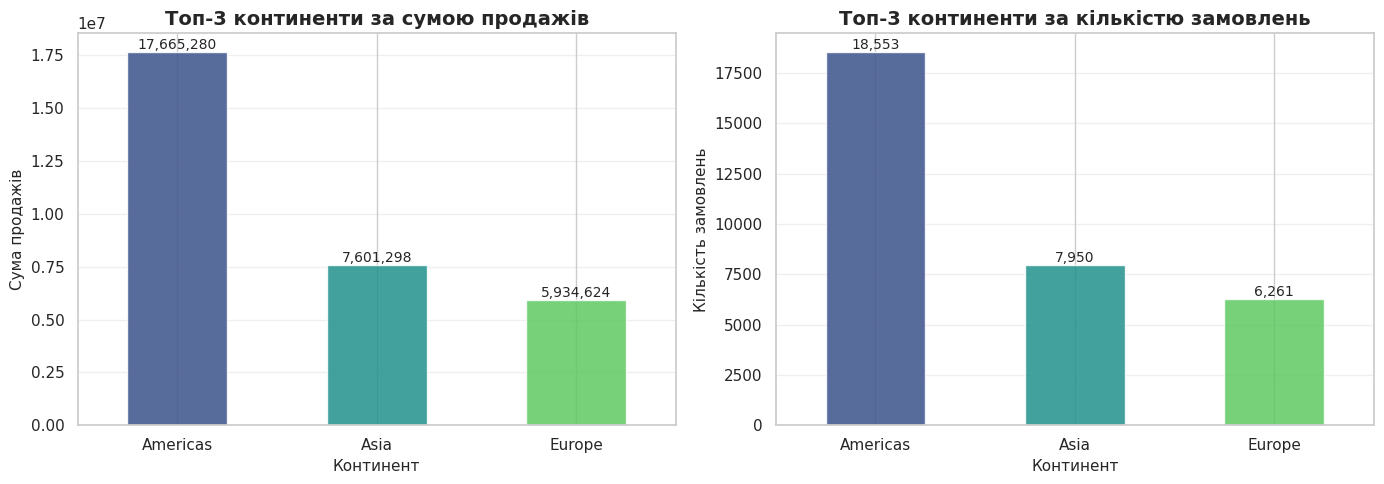

**Америка приносить найбільше грошей і має найбільше замовлень.**
Це означає, що саме цей регіон зараз є ключовим для компанії.**Азія та Європа помітно відстають.**
Різниця в грошах більша, ніж у кількості замовлень, тобто там частіше купують дешевші товари.
Варто або активніше залучати клієнтів у цих регіонах, або працювати над підвищенням середнього чеку.

In [ ]:
sns.set_theme(style="whitegrid", context="notebook")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colors_sales = sns.color_palette("viridis", len(sales_continents))
colors_orders = sns.color_palette("viridis", len(orders_continents))

sales_continents.plot(kind='bar', ax=axes[0], color=colors_sales, alpha=0.85)
axes[0].set_title("Топ-3 континенти за сумою продажів", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Континент", fontsize=11)
axes[0].set_ylabel("Сума продажів", fontsize=11)
axes[0].grid(axis='y', alpha=0.3)
axes[0].tick_params(axis='x', rotation=0)

for i, v in enumerate(sales_continents.values):
    axes[0].text(i, v, f"{v:,.0f}", ha='center', va='bottom', fontsize=10)

orders_continents.plot(kind='bar', ax=axes[1], color=colors_orders, alpha=0.85)
axes[1].set_title("Топ-3 континенти за кількістю замовлень", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Континент", fontsize=11)
axes[1].set_ylabel("Кількість замовлень", fontsize=11)
axes[1].grid(axis='y', alpha=0.3)
axes[1].tick_params(axis='x', rotation=0)

for i, v in enumerate(orders_continents.values):
    axes[1].text(i, v, f"{v:,}", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()
display(Markdown("""**Америка приносить найбільше грошей і має найбільше замовлень.**
Це означає, що саме цей регіон зараз є ключовим для компанії.**Азія та Європа помітно відстають.**
Різниця в грошах більша, ніж у кількості замовлень, тобто там частіше купують дешевші товари.
Варто або активніше залучати клієнтів у цих регіонах, або працювати над підвищенням середнього чеку."""))

In [ ]:
sales_countries = (
    df.dropna(subset=['country', 'price'])
      .groupby('country')['price']
      .sum()
      .nlargest(5))

orders_countries = (
    df.dropna(subset=['country', 'order_date'])
      .groupby('country')['order_date']
      .count()
      .nlargest(5))

display(Markdown("**Топ 5 країн за продажами та кількістю замовлень**"))
result = pd.concat(
    [sales_countries, orders_countries],
    axis=1,
    keys=['total_sales', 'orders_count'])
result

**Топ 5 країн за продажами та кількістю замовлень**

,total_sales,orders_count
country,,
United States,13943553.9,14673
India,2809762.0,3029
Canada,2437921.0,2560
United Kingdom,938317.9,1029
France,710692.8,678


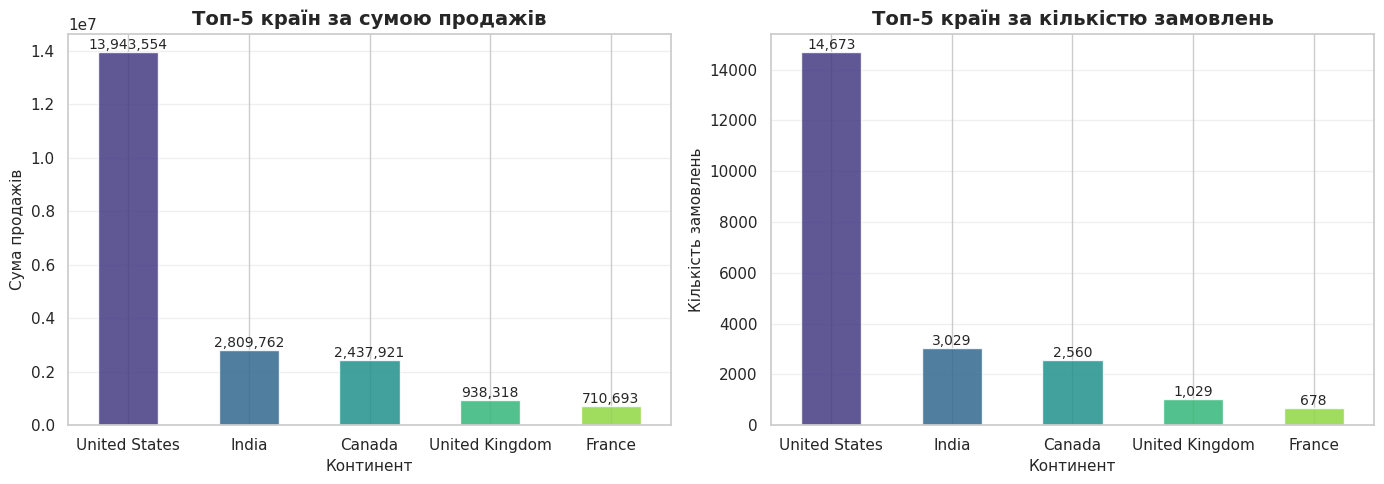

In [ ]:
sns.set_theme(style="whitegrid", context="notebook")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colors_sales = sns.color_palette("viridis", len(sales_countries))
colors_orders = sns.color_palette("viridis", len(orders_countries))

sales_countries.plot(kind='bar', ax=axes[0], color=colors_sales, alpha=0.85)
axes[0].set_title("Топ-5 країн за сумою продажів", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Континент", fontsize=11)
axes[0].set_ylabel("Сума продажів", fontsize=11)
axes[0].grid(axis='y', alpha=0.3)
axes[0].tick_params(axis='x', rotation=0)

for i, v in enumerate(sales_countries.values):
    axes[0].text(i, v, f"{v:,.0f}", ha='center', va='bottom', fontsize=10)

orders_countries.plot(kind='bar', ax=axes[1], color=colors_orders, alpha=0.85)
axes[1].set_title("Топ-5 країн за кількістю замовлень", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Континент", fontsize=11)
axes[1].set_ylabel("Кількість замовлень", fontsize=11)
axes[1].grid(axis='y', alpha=0.3)
axes[1].tick_params(axis='x', rotation=0)

for i, v in enumerate(orders_countries.values):
    axes[1].text(i, v, f"{v:,}", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
display(Markdown("**Топ-10 категорій товарів за загальною сумою продажів**"))
sales_categories = (
   df.dropna(subset=['product_category', 'price'])
      .groupby('product_category')['price']
      .sum()
      .nlargest(10))
sales_categories

**Топ-10 категорій товарів за загальною сумою продажів**

,price
product_category,
Sofas & armchairs,8388254.5
Chairs,6147748.8
Beds,4919725.0
Bookcases & shelving units,3640818.1
Cabinets & cupboards,2336499.5
Outdoor furniture,2142222.2
Tables & desks,1790307.5
Chests of drawers & drawer units,906562.5
Bar furniture,735503.0


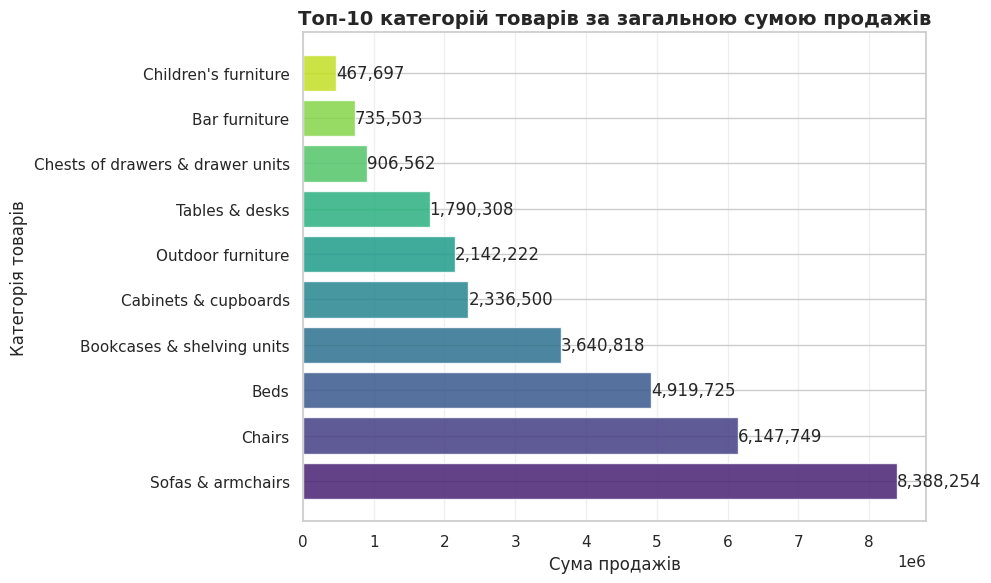

In [ ]:
sns.set_theme(style="whitegrid", context="notebook")

plt.figure(figsize=(10, 6))

colors_categories = sns.color_palette("viridis", len(sales_categories))

ax = plt.barh(
    sales_categories.index,
    sales_categories.values,
    color = colors_categories,
    alpha=0.85)

plt.title("Топ-10 категорій товарів за загальною сумою продажів",
          fontsize=14, fontweight="bold")
plt.xlabel("Сума продажів")
plt.ylabel("Категорія товарів")

plt.grid(axis='x', alpha=0.3)

for i, v in enumerate(sales_categories.values):
    plt.text(v, i, f"{v:,.0f}", va='center', ha='left')

plt.tight_layout()
plt.show()


In [ ]:
top_country = (
    df.dropna(subset=['country', 'price'])
      .groupby('country')['price']
      .sum()
      .idxmax())

top_country_sales_categories = (
       df[df['country'] == top_country]
      .dropna(subset=['product_category', 'price'])
      .groupby('product_category')['price']
      .sum()
      .nlargest(10))

display(Markdown("**Топ-10 категорій товарів у країні з найбільшими продажами**"))
print(top_country)
top_country_sales_categories

**Топ-10 категорій товарів у країні з найбільшими продажами**

United States


,price
product_category,
Sofas & armchairs,3707144.5
Chairs,2619773.8
Beds,2213058.0
Bookcases & shelving units,1567606.9
Cabinets & cupboards,994545.5
Outdoor furniture,929245.2
Tables & desks,777865.0
Chests of drawers & drawer units,382388.0
Bar furniture,330805.0


In [ ]:
display(Markdown("**Порівняння**"))
comparison = (
    pd.concat(
        [sales_categories, top_country_sales_categories],
        axis=1,
        keys=['global_sales', f'{top_country}_sales'])
    .fillna(0))
comparison

**Порівняння**

,global_sales,United States_sales
product_category,,
Sofas & armchairs,8388254.5,3707144.5
Chairs,6147748.8,2619773.8
Beds,4919725.0,2213058.0
Bookcases & shelving units,3640818.1,1567606.9
Cabinets & cupboards,2336499.5,994545.5
Outdoor furniture,2142222.2,929245.2
Tables & desks,1790307.5,777865.0
Chests of drawers & drawer units,906562.5,382388.0
Bar furniture,735503.0,330805.0


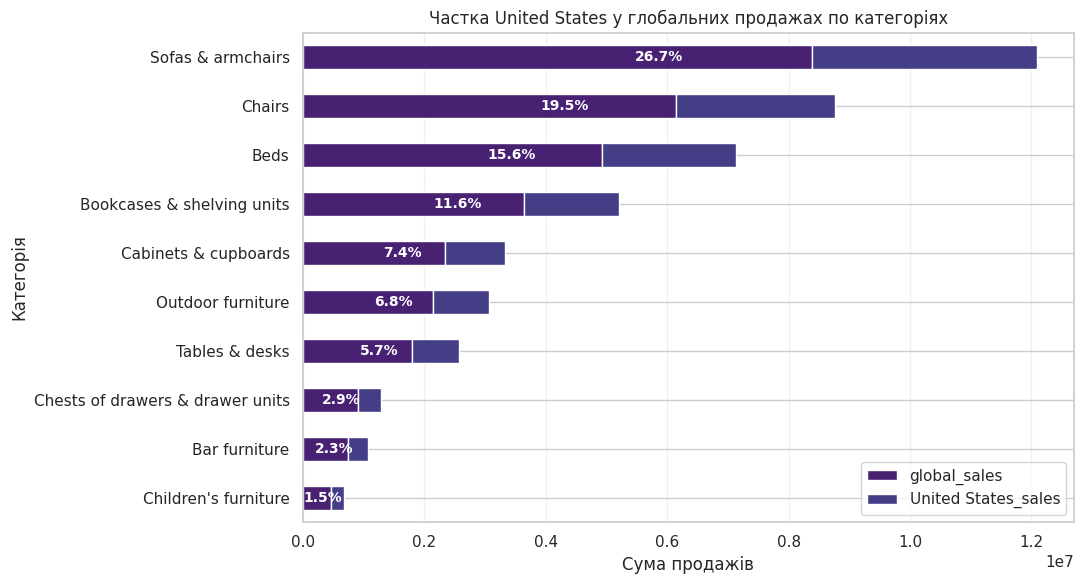

In [ ]:
sns.set_theme(style="whitegrid", context="notebook")

colors_categories = sns.color_palette("viridis", len(comparison))

comparison_plot = comparison.sort_values("global_sales", ascending=True)

ax = comparison_plot.plot(
    kind="barh",
    stacked=True,
    figsize=(11,6),
    color=colors_categories)

plt.xlabel("Сума продажів")
plt.ylabel("Категорія")
plt.title(f"Частка {top_country} у глобальних продажах по категоріях")
plt.grid(axis="x", alpha=0.3)

total_sales = comparison_plot["global_sales"].sum()
for i, (val, cat) in enumerate(zip(comparison_plot["global_sales"], comparison_plot.index)):
    percent = val / total_sales * 100
    ax.text(val * 0.7, i, f"{percent:.1f}%", va="center", ha="center", color="white", fontsize=10, fontweight="bold")

plt.tight_layout()
plt.show()


**США** — країна з найбільшими продажами.

Топ-категорії товарів у США майже повністю збігаються з глобальними: лідирують *Sofas & armchairs, Chairs* та *Beds*.

Суттєвих відмінностей від загальної картини немає — структура попиту подібна до глобальної.

In [ ]:
device_sales_pct = (
    df.dropna(subset=['device', 'price'])
      .groupby('device')['price']
      .sum())

device_sales_pct = (
    device_sales_pct / device_sales_pct.sum() * 100
).round(2)

display(Markdown("**Продажі за типами девайсів (%)**"))
device_sales_pct


**Продажі за типами девайсів (%)**

,price
device,
desktop,59.00
mobile,38.73
tablet,2.26


In [ ]:
mobile_model_sales_pct = (
    df[df['device'] == 'mobile']
      .dropna(subset=['mobile_model_name', 'price'])
      .groupby('mobile_model_name')['price']
      .sum())

mobile_model_sales_pct = (
    mobile_model_sales_pct / mobile_model_sales_pct.sum() * 100
).round(2)

display(Markdown("**Продажі за моделями телефонів (%)**"))
mobile_model_sales_pct.sort_values(ascending=False).head(10)


**Продажі за моделями телефонів (%)**

,price
mobile_model_name,
iPhone,51.85
<Other>,46.31
Pixel 4 XL,0.96
Pixel 3,0.88
Edge,0.00
Safari,0.00


In [ ]:
traffic_chanel_sales_pct = (
    df.dropna(subset=['traffic_channel', 'price'])
      .groupby('traffic_channel')['price']
      .sum())

traffic_chanel_sales_pct = (
    traffic_chanel_sales_pct / traffic_chanel_sales_pct.sum() * 100
).round(2)

display(Markdown("**Продажі за джерелами трафіку (%)**"))
traffic_chanel_sales_pct

**Продажі за джерелами трафіку (%)**

,price
traffic_channel,
Direct,23.44
Organic Search,35.76
Paid Search,26.62
Social Search,7.92
Undefined,6.26


In [ ]:
registered_users = df.dropna(subset=['account_id'])
verified_accounts = (
    (registered_users['is_email_verified'] == True).sum()
    / len(registered_users) * 100)
verified_accounts=round(verified_accounts, 2)

print(f'{verified_accounts} % зареєстрованих користувачів підтвердили свою електронну адресу.')

71.52 % зареєстрованих користувачів підтвердили свою електронну адресу.


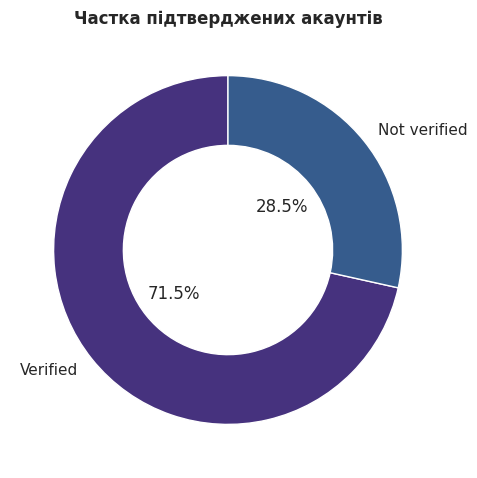

In [ ]:
sns.set_theme(style="whitegrid")

colors_verified = sns.color_palette("viridis")

sizes = [verified_accounts, 100 - verified_accounts]
labels = ["Verified", "Not verified"]

plt.figure(figsize=(5,5))
plt.pie(
    sizes,
    labels=labels,
    autopct="%1.1f%%",
    startangle=90,
    wedgeprops=dict(width=0.4),
    colors = colors_verified,
    pctdistance=0.40,
    labeldistance=1.1  )

plt.title("Частка підтверджених акаунтів", fontweight="bold")
plt.tight_layout()
plt.show()


In [ ]:
unsubscribed_accounts = (
    (registered_users['is_unsubscribed'] == True).sum()
    / len(registered_users) * 100)

unsubscribed_accounts=round(unsubscribed_accounts, 2)
print(f'{unsubscribed_accounts} % зареєстрованих користувачів відписалися від розсилки.')

16.07 % зареєстрованих користувачів відписалися від розсилки.


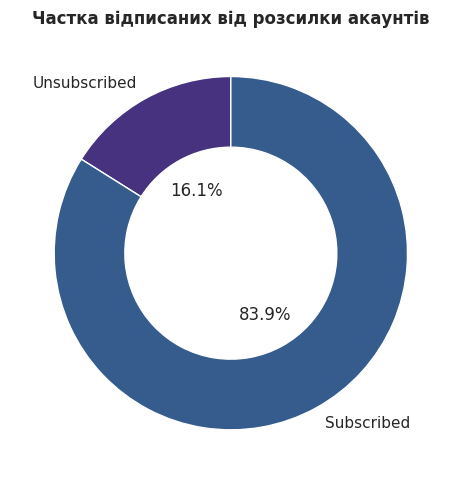

In [ ]:
sns.set_theme(style="whitegrid")

colors_unsubscribed = sns.color_palette("viridis")

sizes = [unsubscribed_accounts, 100 - unsubscribed_accounts]
labels = ["Unsubscribed", "Subscribed"]

plt.figure(figsize=(5,5))
plt.pie(
    sizes,
    labels=labels,
    autopct="%1.1f%%",
    startangle=90,
    wedgeprops=dict(width=0.4),
    colors = colors_unsubscribed,
    pctdistance=0.40,
    labeldistance=1.1)

plt.title("Частка відписаних від розсилки акаунтів", fontweight="bold")
plt.tight_layout()
plt.show()

In [ ]:
unsubscribe_sales = (
    df.dropna(subset=['is_unsubscribed', 'price'])
      .groupby('is_unsubscribed')['price']
      .agg(['count', 'sum', 'mean'])
      .rename(columns={
          'count': 'orders_count',
          'sum': 'total_sales',
          'mean': 'avg_order_value'}))

unsubscribe_sales.index = unsubscribe_sales.index.map({
    0: 'Subscribed',
    1: 'Unsubscribed'})

unsubscribe_sales = unsubscribe_sales.rename(columns={
    'orders_count': 'Orders',
    'total_sales': 'Total sales',
    'avg_order_value': 'Avg order value'})

unsubscribe_sales['Total sales'] = unsubscribe_sales['Total sales'].round(2)
unsubscribe_sales['Avg order value'] = unsubscribe_sales['Avg order value'].round(2)

display(Markdown("**Поведінка тих, хто відписався від розсилки та тих, хто досі підписаний**"))
unsubscribe_sales


**Поведінка тих, хто відписався від розсилки та тих, хто досі підписаний**

,Orders,Total sales,Avg order value
is_unsubscribed,,,
Subscribed,2334,2150796.9,921.51
Unsubscribed,447,431721.6,965.82


In [ ]:
display(Markdown("**Країни в яких найбільше зареєстрованих користувачів**"))
top_countries_registered = (
    df.dropna(subset=['account_id', 'country'])
      .groupby('country')['account_id']
      .nunique()
      .sort_values(ascending=False)
      .head(5))

top_countries_registered

**Країни в яких найбільше зареєстрованих користувачів**

,account_id
country,
United States,1207
India,246
Canada,207
United Kingdom,88
France,56


In [ ]:
avg_by_continent = (
    df.dropna(subset=['continent', 'price'])
      .groupby('continent')['price']
      .mean()
      .round(2)
      .sort_values(ascending=False)
      .head(5))

display(Markdown("**Середній чек по континентах**"))
avg_by_continent

**Середній чек по континентах**

,price
continent,
(not set),1043.20
Oceania,1003.38
Africa,977.08
Asia,956.14
Americas,952.15


#**Sales dynamics analysis**

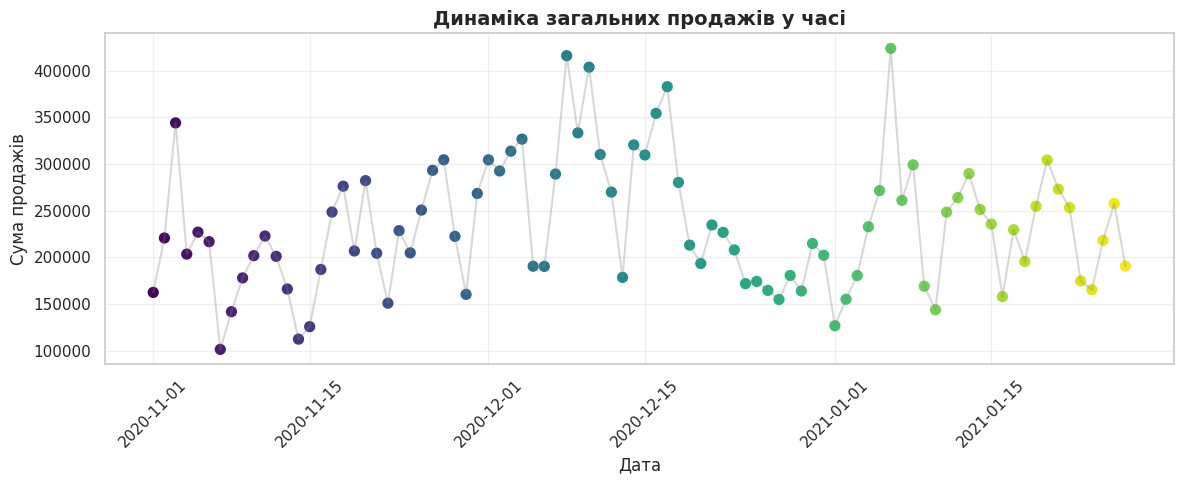

In [ ]:
daily_sales = (
    clean_df
    .groupby('order_date')['price']
    .sum()
    .sort_index())

plt.figure(figsize=(12,5))
colors = sns.color_palette("viridis", len(daily_sales))

plt.scatter(daily_sales.index, daily_sales.values, color=colors, s=50)
plt.plot(daily_sales.index, daily_sales.values, color='gray', alpha=0.3)

plt.title("Динаміка загальних продажів у часі", fontsize=14, fontweight="bold")
plt.xlabel("Дата")
plt.ylabel("Сума продажів")
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


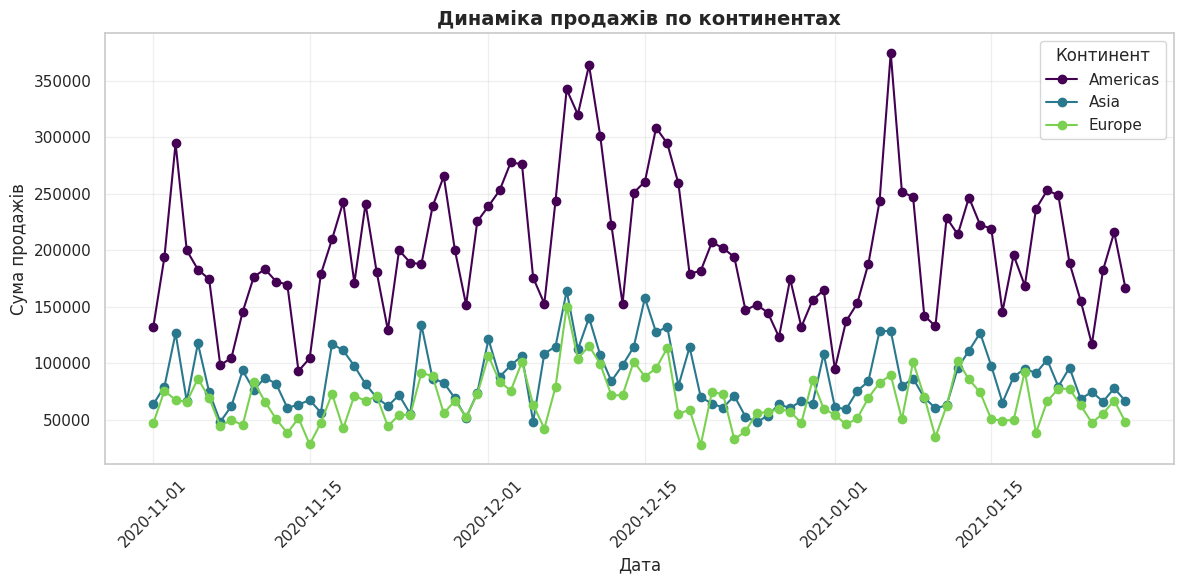

In [ ]:
sns.set_theme(style="whitegrid", context="notebook")

continents = ["Americas", "Asia", "Europe"]

plt.figure(figsize=(12,6))

colors = {"Americas": "#440154ff", "Asia": "#2a788eff", "Europe": "#7ad151ff"}

for cont in continents:
    df_cont = df[df['continent'] == cont]
    daily_sales_cont = (
        df_cont.groupby('order_date')['price']
        .sum()
        .sort_index())

    plt.plot(
        daily_sales_cont.index,
        daily_sales_cont.values,
        marker='o',
        color=colors[cont],
        label=cont)

plt.title("Динаміка продажів по континентах", fontsize=14, fontweight="bold")
plt.xlabel("Дата")
plt.ylabel("Сума продажів")
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.legend(title="Континент")
plt.tight_layout()
plt.show()


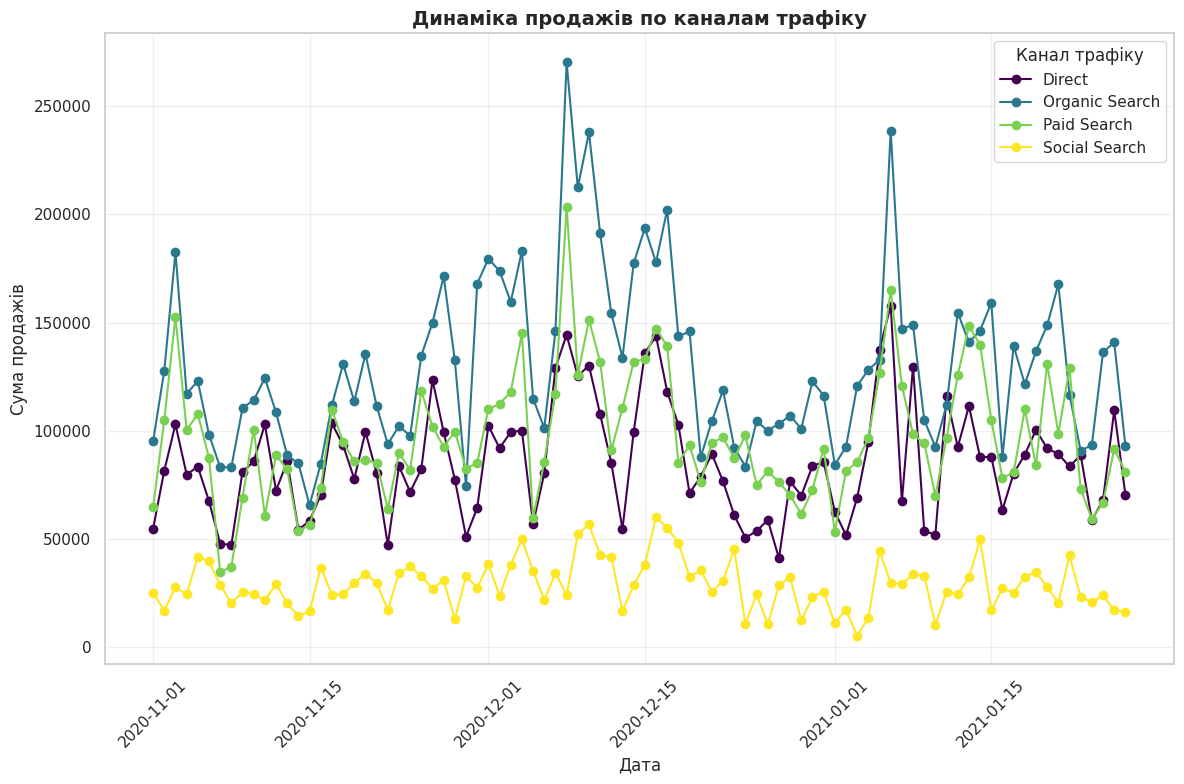

In [ ]:
sns.set_theme(style="whitegrid", context="notebook")

traffic_channel = ["Direct", "Organic Search", "Paid Search", "Social Search"]

plt.figure(figsize=(12,8))

colors = {"Direct": "#440154ff", "Organic Search": "#2a788eff", "Paid Search": "#7ad151ff", "Social Search": "#fde725ff"}

for chan in traffic_channel:
    df_chan = df[df['traffic_channel'] == chan]
    daily_sales_chan = (
        df_chan.groupby('order_date')['price']
        .sum()
        .sort_index())

    plt.plot(
        daily_sales_chan.index,
        daily_sales_chan.values,
        marker='o',
        color=colors[chan],
        label=chan)

plt.title("Динаміка продажів по каналам трафіку", fontsize=14, fontweight="bold")
plt.xlabel("Дата")
plt.ylabel("Сума продажів")
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.legend(title="Канал трафіку")
plt.tight_layout()
plt.show()

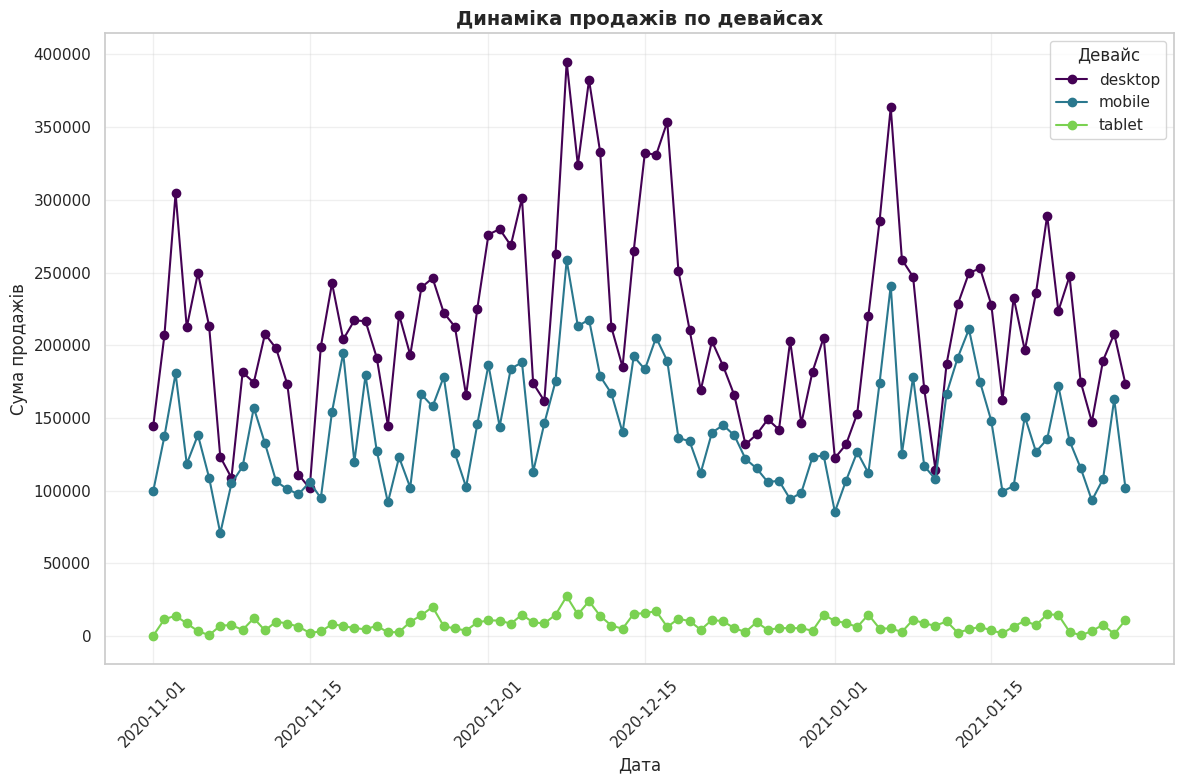

In [ ]:
sns.set_theme(style="whitegrid", context="notebook")

device = ["desktop", "mobile", "tablet"]
plt.figure(figsize=(12,8))

colors = {"desktop": "#440154ff", "mobile": "#2a788eff", "tablet": "#7ad151ff"}

for dev in device:
    df_dev = df[df['device'] == dev]
    daily_sales_dev = (
        df_dev.groupby('order_date')['price']
        .sum()
        .sort_index())

    plt.plot(
        daily_sales_dev.index,
        daily_sales_dev.values,
        marker='o',
        color=colors[dev],
        label=dev)

plt.title("Динаміка продажів по девайсах", fontsize=14, fontweight="bold")
plt.xlabel("Дата")
plt.ylabel("Сума продажів")
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.legend(title="Девайс")
plt.tight_layout()
plt.show()

# **Vizualizations**

In [ ]:
clean_df = df.dropna(subset=['session_id', 'traffic_channel', 'device'])

pivot_sessions = pd.pivot_table(
    clean_df,
    values='session_id',
    index='traffic_channel',
    columns='device',
    aggfunc='nunique',
    fill_value=0
)
display(Markdown("**Кількість сесій у розрізі каналів трафіку та типів девайсів**"))
pivot_sessions


**Кількість сесій у розрізі каналів трафіку та типів девайсів**

device,desktop,mobile,tablet
traffic_channel,,,
Direct,4655,2985,160
Organic Search,7011,4655,255
Paid Search,5261,3574,207
Social Search,1594,1065,57
Undefined,1181,834,44


In [ ]:
clean_df = df[
    (df['country'].isin(sales_countries)) &
    (df['product_category'].isin(sales_categories.index))
].dropna(subset=['price', 'product_category', 'country'])

pivot_sales = pd.pivot_table(
    clean_df,
    values='price',
    index='product_category',
    columns='country',
    aggfunc='sum',
    fill_value=0)
display(Markdown("**Загальні продажі за категоріями товарів у різних країнах**"))
pivot_sales

**Загальні продажі за категоріями товарів у різних країнах**

country,Canada,France,India,United Kingdom,United States
product_category,,,,,
Bar furniture,51724.0,11199.0,57657.0,22103.0,330805.0
Beds,354772.0,116414.0,358319.5,133816.0,2213058.0
Bookcases & shelving units,278981.9,73830.0,364507.4,113987.6,1567606.9
Cabinets & cupboards,181802.0,59101.5,191888.0,71684.5,994545.5
Chairs,417740.8,134029.4,544309.2,188519.4,2619773.8
Chests of drawers & drawer units,71952.0,21544.5,73111.0,36784.0,382388.0
Children's furniture,30264.0,14258.0,39177.0,13348.0,207575.0
Outdoor furniture,185322.8,40486.4,162289.4,57002.4,929245.2
Sofas & armchairs,692427.5,187735.0,788430.0,234812.0,3707144.5


# **Statistical analysis of relationships**


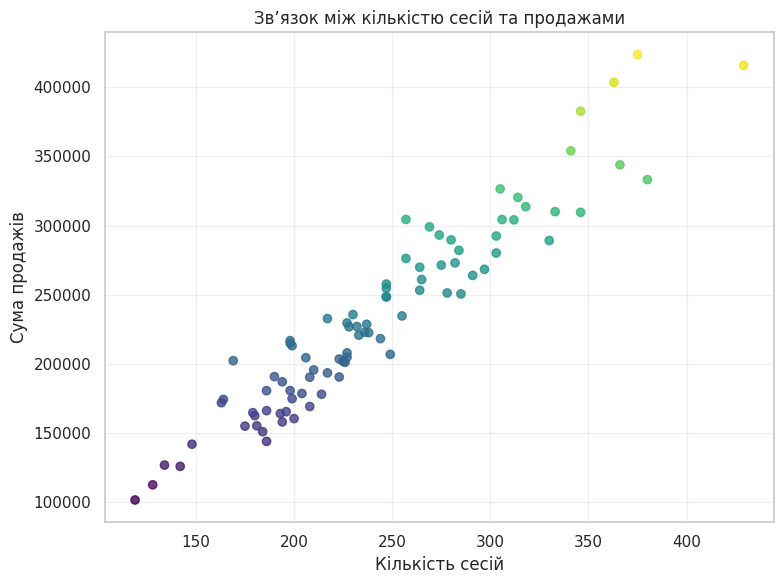

Коефіцієнт кореляції Пірсона: 0.953
p-value: 0.000000
Висновок: кореляція статистично значуща


Коефіцієнт кореляції Пірсона між кількістю сесій та сумою продажів становить **r = 0.953**, що свідчить про **дуже сильний позитивний звʼязок** між показниками.Значення **p-value < 0.001** підтверджує, що виявлена кореляція є **статистично значущою** і не є випадковою. Отже, зі збільшенням кількості сесій спостерігається **суттєве зростання загального обсягу продажів**.

In [ ]:
daily_sales = (
    clean_df
    .groupby('order_date')['price']
    .sum()
    .sort_index())

daily_sessions = (
    clean_df
    .groupby('order_date')['session_id']
    .nunique()
    .sort_index())
plt.figure(figsize=(8,6))
plt.scatter(
    daily_sessions.values,
    daily_sales.values,
    c=daily_sales.values,
    cmap='viridis',
    alpha=0.8)

plt.title("Звʼязок між кількістю сесій та продажами")
plt.xlabel("Кількість сесій")
plt.ylabel("Сума продажів")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

corr, p_value = pearsonr(daily_sessions.values, daily_sales.values)

print(f"Коефіцієнт кореляції Пірсона: {corr:.3f}")
print(f"p-value: {p_value:.6f}")

if p_value < 0.05:
    print("Висновок: кореляція статистично значуща")
else:
    print("Висновок: кореляція не є статистично значущою")
display(Markdown("Коефіцієнт кореляції Пірсона між кількістю сесій та сумою продажів становить **r = 0.953**, що свідчить про **дуже сильний позитивний звʼязок** між показниками.Значення **p-value < 0.001** підтверджує, що виявлена кореляція є **статистично значущою** і не є випадковою. Отже, зі збільшенням кількості сесій спостерігається **суттєве зростання загального обсягу продажів**."))

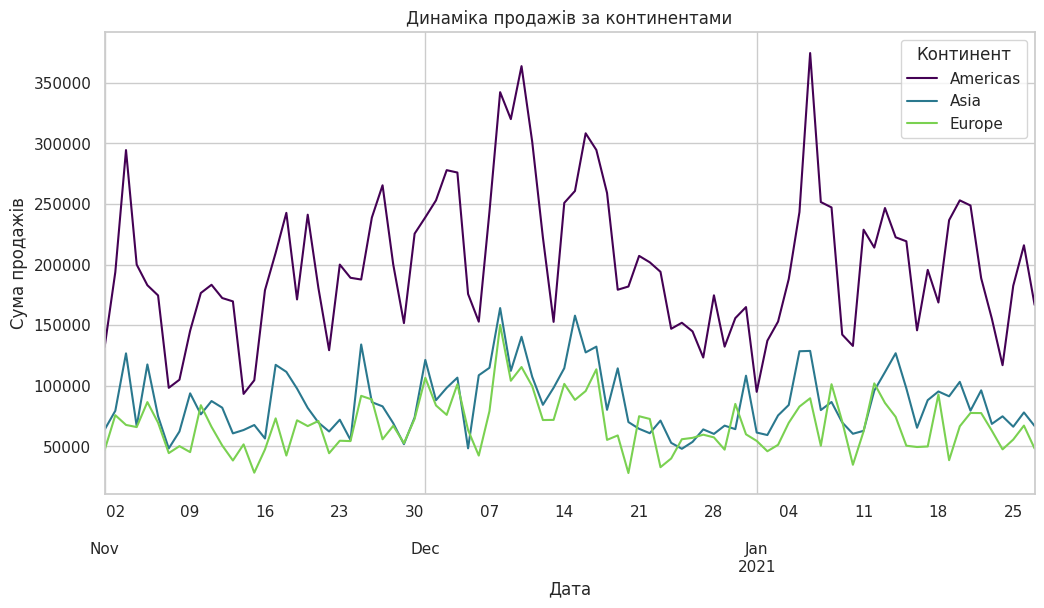

,Continent 1,Continent 2,Pearson r,p-value
0,Americas,Asia,0.692273,8.004063e-14
1,Americas,Europe,0.669527,9.911408e-13
2,Asia,Europe,0.667786,1.190893e-12


In [ ]:
df['order_date'] = pd.to_datetime(df['order_date'])

top3 = (
    df.groupby('continent')['price']
      .sum()
      .sort_values(ascending=False)
      .head(3)
      .index
)

top3
sales_by_date = (
    df[df['continent'].isin(top3)]
    .groupby(['order_date', 'continent'])['price']
    .sum()
    .reset_index()
)

pivot_cont = sales_by_date.pivot(
    index='order_date',
    columns='continent',
    values='price'
).fillna(0)

results = []

for c1, c2 in combinations(pivot_cont.columns, 2):
    r, p = pearsonr(pivot_cont[c1], pivot_cont[c2])
    results.append([c1, c2, r, p])
colors = ['#440154ff', '#2a788eff', '#7ad151ff']

pivot_cont.plot(figsize=(12,6), color=colors)
plt.title("Динаміка продажів за континентами")
plt.xlabel("Дата")
plt.ylabel("Сума продажів")
plt.legend(title="Континент")
plt.show()
corr_df = pd.DataFrame(
    results,
    columns=['Continent 1', 'Continent 2', 'Pearson r', 'p-value'])

corr_df

Аналіз кореляції Пірсона для топ-3 континентів (*Americas, Asia, Europe*) показав наявність **статистично значущого позитивного взаємозвʼязку** між динамікою продажів у всіх парах регіонів.

Значення коефіцієнтів *r ≈ 0.67–0.69* свідчать про **середньо-сильну кореляцію**, тобто продажі на різних континентах змінюються узгоджено.

Дуже малі значення p-value *(< 0.001)* підтверджують, що ці звʼязки **не є випадковими**. Це може вказувати на спільні сезонні ефекти, глобальні маркетингові кампанії або загальні тенденції попиту, що впливають на всі регіони одночасно.

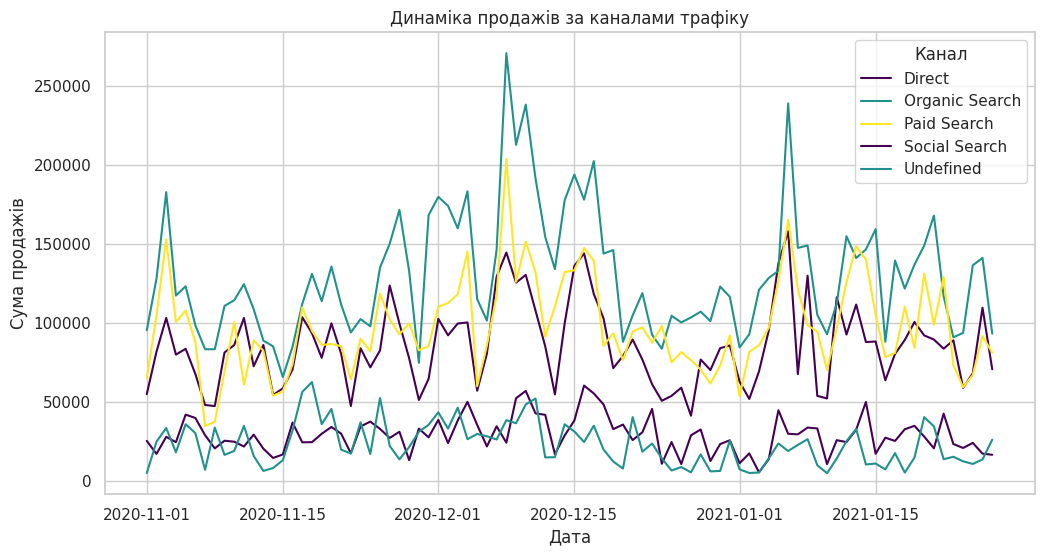

,Сhannel 1,Сhannel 2,Pearson r,p-value
0,Direct,Organic Search,0.759938,9.107881e-18
1,Direct,Paid Search,0.724343,1.512880e-15
2,Direct,Social Search,0.461895,5.901047e-06
3,Direct,Undefined,0.424039,3.838547e-05
4,Organic Search,Paid Search,0.808234,1.755643e-21
5,Organic Search,Social Search,0.434424,2.347593e-05
6,Organic Search,Undefined,0.435418,2.237821e-05
7,Paid Search,Social Search,0.452287,9.696038e-06
8,Paid Search,Undefined,0.430021,2.897496e-05
9,Social Search,Undefined,0.359342,5.853111e-04


In [ ]:
sales_by_channel = (
    df[['order_date', 'traffic_channel', 'price']]
    .groupby(['order_date', 'traffic_channel'])['price']
    .sum()
    .reset_index()
)

pivot_channel = sales_by_channel.pivot(
    index='order_date',
    columns='traffic_channel',
    values='price'
).fillna(0)

n_lines = pivot_sales.shape[1]
colors = cm.viridis(np.linspace(0, 1, n_lines))

pivot_channel.plot(figsize=(12,6), color=colors)
plt.title("Динаміка продажів за каналами трафіку")
plt.xlabel("Дата")
plt.ylabel("Сума продажів")
plt.legend(title="Канал")
plt.show()

results = []

for c1, c2 in combinations(pivot_channel.columns, 2):
    r, p = pearsonr(pivot_channel[c1], pivot_channel[c2])
    results.append([c1, c2, r, p])

corr_df = pd.DataFrame(
    results,
    columns=['Сhannel 1', 'Сhannel 2', 'Pearson r', 'p-value'])

corr_df


Кореляційний аналіз між каналами трафіку показав наявність позитивних та статистично значущих зв’язків між більшістю пар каналів. Найсильніша кореляція спостерігається між Organic Search та Paid Search (r = 0.81), а також між Direct та Organic Search (r = 0.76) і Direct та Paid Search (r = 0.72), що свідчить про синхронну динаміку продажів у цих каналах.

Для пар із Social Search кореляція є помірною (r ≈ 0.43–0.46), а найслабший, але статистично значущий зв’язок виявлено між Social Search та Undefined (r = 0.36).

Усі отримані p-value < 0.001, що підтверджує статистичну значущість результатів та не випадковий характер взаємозв’язків.

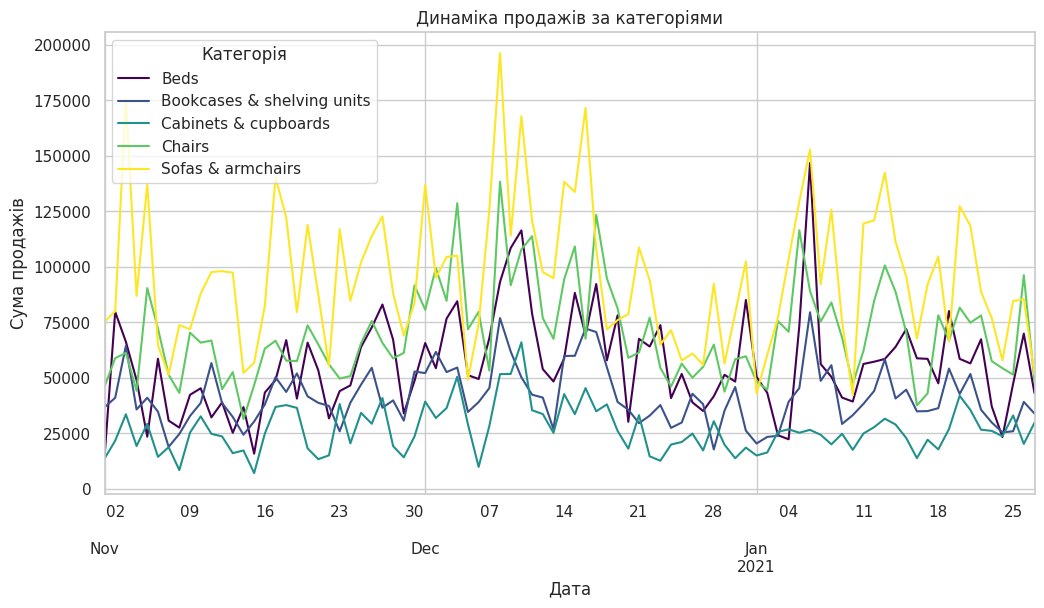

,Category 1,Category 2,Pearson r,p-value
0,Beds,Bookcases & shelving units,0.592913,1.154998e-09
1,Beds,Cabinets & cupboards,0.514609,2.910930e-07
2,Beds,Chairs,0.554500,2.079183e-08
3,Beds,Sofas & armchairs,0.535378,7.687333e-08
4,Bookcases & shelving units,Cabinets & cupboards,0.539428,5.867225e-08
5,Bookcases & shelving units,Chairs,0.637090,2.504550e-11
6,Bookcases & shelving units,Sofas & armchairs,0.666194,1.406972e-12
7,Cabinets & cupboards,Chairs,0.572870,5.465903e-09
8,Cabinets & cupboards,Sofas & armchairs,0.657563,3.415056e-12
9,Chairs,Sofas & armchairs,0.578248,3.638833e-09


In [ ]:
top5 = (
    df.groupby('product_category')['price']
      .sum()
      .sort_values(ascending=False)
      .head(5)
      .index)

top5
sales_by_category = (
    df[df['product_category'].isin(top5)]
    .groupby(['order_date', 'product_category'])['price']
    .sum()
    .reset_index())

pivot_cat = sales_by_category.pivot(
    index='order_date',
    columns='product_category',
    values='price'
).fillna(0)

results = []

for c1, c2 in combinations(pivot_cat.columns, 2):
    r, p = pearsonr(pivot_cat[c1], pivot_cat[c2])
    results.append([c1, c2, r, p])
n_lines = pivot_cat.shape[1]
colors = cm.viridis(np.linspace(0, 1, n_lines))

pivot_cat.plot(figsize=(12,6), color=colors)
plt.title("Динаміка продажів за категоріями")
plt.xlabel("Дата")
plt.ylabel("Сума продажів")
plt.legend(title="Категорія")
plt.show()
corr_df = pd.DataFrame(
    results,
    columns=['Category 1', 'Category 2', 'Pearson r', 'p-value'])

corr_df

Аналіз кореляції Пірсона між продажами різних категорій товарів показав, що всі розглянуті пари мають **позитивний та статистично значущий зв’язок**.
*
Усі *p-value < 0.001*, що підтверджує, що виявлені **кореляції не є випадковими**.

# **Statistical analysis of differences**

In [ ]:
# Вибірки
registered = df[df['is_email_verified'] == True]
unregistered = df[df['is_email_verified'] == False]

# Групування по даті та підрахунок продажів (сума по ціні)
sales_registered = registered.groupby('order_date')['price'].sum()
sales_unregistered = unregistered.groupby('order_date')['price'].sum()

,price
order_date,
2020-11-01,10517.0
2020-11-02,35662.0
2020-11-03,24177.5
2020-11-04,11814.6
2020-11-05,22278.6
...,...
2021-01-23,14432.0
2021-01-24,18494.0
2021-01-25,22622.8


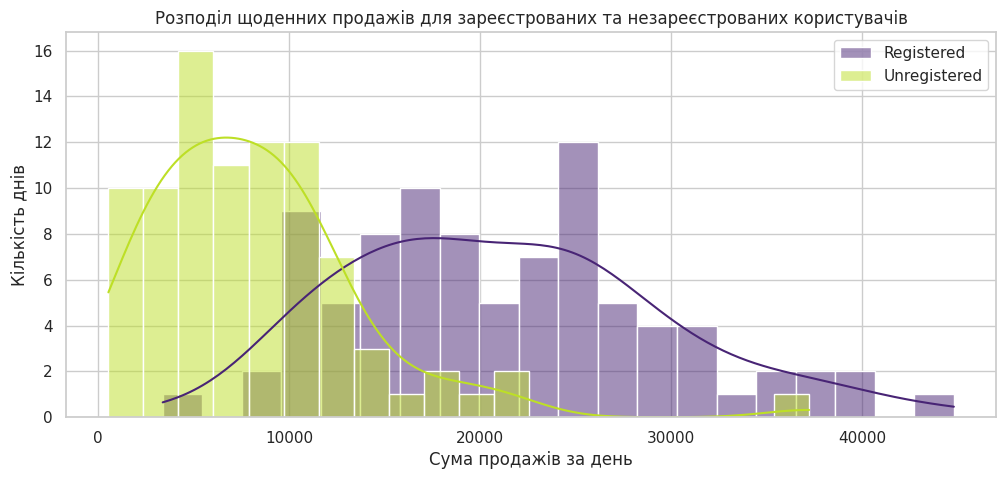

In [ ]:
cmap = plt.get_cmap('viridis')
color_registered = cmap(0.1)
color_unregistered = cmap(0.9)
sns.set_theme(style="whitegrid", context="notebook")
plt.figure(figsize=(12,5))
sns.histplot(sales_registered, color=color_registered, label='Registered', kde=True, bins=20)
sns.histplot(sales_unregistered, color=color_unregistered, label='Unregistered', kde=True, bins=20)
plt.legend()
plt.xlabel('Сума продажів за день')
plt.ylabel('Кількість днів')
plt.title('Розподіл щоденних продажів для зареєстрованих та незареєстрованих користувачів')
plt.show()

In [ ]:
print("Registered normality p-value:", shapiro(sales_registered).pvalue)
print("Unregistered normality p-value:", shapiro(sales_unregistered).pvalue)

Registered normality p-value: 0.11325964679068223
Unregistered normality p-value: 1.660135980785686e-07


In [ ]:
stat, p = mannwhitneyu(sales_registered, sales_unregistered, alternative='two-sided')

print(f"Mann–Whitney U test:")
print(f"Statistic = {stat:.3f}")
print(f"p-value = {p:.6f}")

if p < 0.05:
    print("Висновок: різниця між продажами статистично значуща.")
else:
    print("Висновок: статистично значущої різниці не виявлено.")

Mann–Whitney U test:
Statistic = 7147.000
p-value = 0.000000
Висновок: різниця між продажами статистично значуща.


Для порівняння щоденних продажів зареєстрованих та незареєстрованих користувачів було сформовано дві незалежні вибірки. Нормальність розподілу перевірено тестом Шапіро–Уїлка, який показав відхилення від нормальності для групи незареєстрованих користувачів. Тому для перевірки гіпотези було використано непараметричний критерій Манна–Уїтні. За результатами тесту отримано значення U = 7147 та p-value < 0.001, що дозволяє відхилити нульову гіпотезу про рівність розподілів. Таким чином, між продажами зареєстрованих і незареєстрованих користувачів існує статистично значуща різниця.

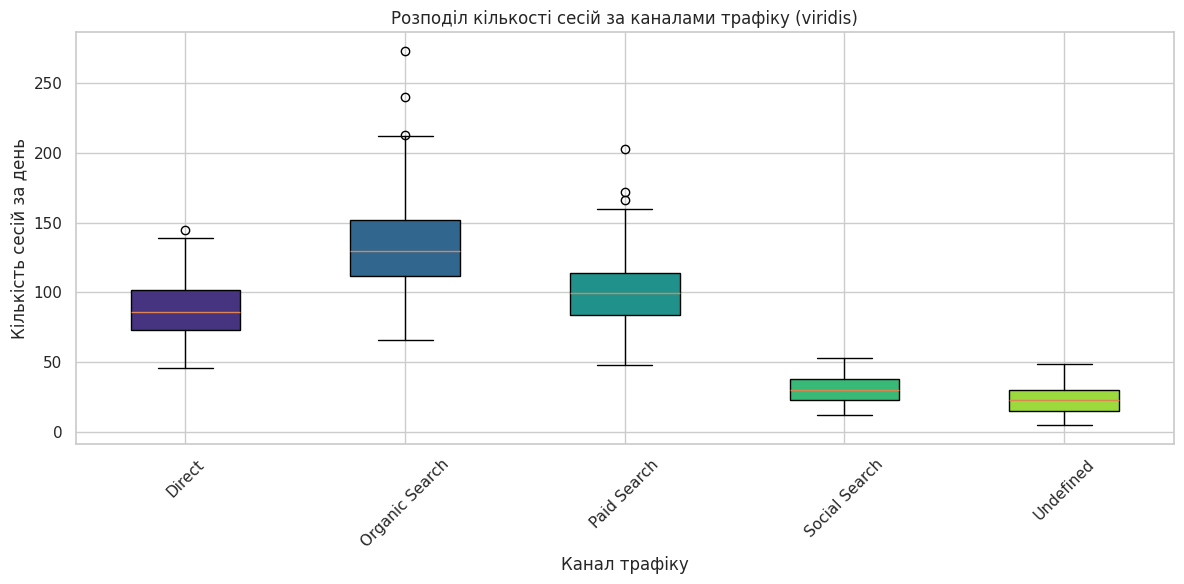

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
sns.set_theme(style="whitegrid", context="notebook")

channels = sessions_by_channel['traffic_channel'].unique()
data = [
    sessions_by_channel[sessions_by_channel['traffic_channel'] == ch]['session_id']
    for ch in channels
]

cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0.15, 0.85, len(data)))

bp = ax.boxplot(data, patch_artist=True)

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

ax.set_xticklabels(channels, rotation=45)
ax.set_title('Розподіл кількості сесій за каналами трафіку (viridis)')
ax.set_xlabel('Канал трафіку')
ax.set_ylabel('Кількість сесій за день')

plt.tight_layout()
plt.show()


In [ ]:
sessions_by_channel.groupby('traffic_channel')['session_id'].mean().sort_values(ascending=False)


,session_id
traffic_channel,
Organic Search,135.465909
Paid Search,102.750000
Direct,88.636364
Social Search,30.863636
Undefined,23.397727


In [ ]:
stat, p = kruskal(*groups)

print(f"Kruskal–Wallis statistic = {stat:.4f}")
print(f"p-value = {p:.6f}")

if p < 0.05:
    print("Висновок: між каналами трафіку є статистично значущі відмінності.")
else:
    print("Висновок: статистично значущих відмінностей між каналами не виявлено.")

Kruskal–Wallis statistic = 349.4251
p-value = 0.000000
Висновок: між каналами трафіку є статистично значущі відмінності.


Для аналізу кількості сесій за каналами трафіку було сформовано вибірки на основі щоденної кількості унікальних сесій у кожному каналі. Оскільки порівнювалось більше двох груп і розподіли не гарантують нормальність, для перевірки гіпотези було застосовано непараметричний критерій Краскела–Уолліса. За результатами тесту отримано значення статистики H = 349.43 та p-value < 0.001, що дозволяє відхилити нульову гіпотезу про рівність розподілів. Таким чином, між каналами трафіку існують статистично значущі відмінності за кількістю сесій, тобто джерело трафіку суттєво впливає на активність користувачів.Найбільшу середню кількість сесій демонструє канал organic search, тоді як найменшу — social search.

# **Dashboard**

https://public.tableau.com/views/SalesOverwiew_17703884729330/Dashboard1?:language=en-US&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link